In [1]:
#import libraries
import numpy as np
import pandas as pd
import networkx as nx
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

In [2]:
%matplotlib inline
import seaborn
plt.style.use('seaborn')#switch to seaborn style# TODO
seaborn.set_style(style='white')

In [3]:
tracks = pd.read_csv('data/tracks.csv', index_col=0, header=[0, 1]);
#load and normalize features
features= pd.read_csv('data/features.csv', index_col=0, header=[0, 1, 2])
dfmax=abs(features).max()
features=features.divide(dfmax)

genres=pd.read_csv('data/genres.csv', index_col=0, header=[0])


In [121]:
# Keep only the genre for each track
label=pd.DataFrame({('label','genre','main'): tracks['track']['genre_top'],
                    ('label','genre','sub'): tracks['track']['genres']})

# Keep on the tracks from small subset
label = label[tracks['set','subset'] == 'small']


# Keep only the genres we want
genre_list = ['Rock','Folk','Hip-Hop']#['Hip-Hop', 'Folk',Rock','Jazz','Classical','Pop','Electronic']
label = label[label['label']['genre']['main'].isin(genre_list)]

#add sub genres
genres_dict=genres['title'].to_dict()
genres_dict={str(key):genres_dict[key] for key in genres_dict}

label['label']['genre']['sub']=label['label']['genre']['sub'].str.replace('[^0-9| ]','').str.split(' ').apply(lambda x:'|'.join([genres_dict[k] for k in x ]))


# Merging
dataSet = features.merge(label, left_index=True, right_on='track_id')
#dataSet=dataSet.sort_values([('label', 'genre','main')])


In [122]:
print(sum(dataSet.label.genre.main=='Rock'))
label.label.genre.main.unique()

1000


array(['Hip-Hop', 'Folk', 'Rock'], dtype=object)

In [123]:
#we calculate the distances of our dataset
distances = pdist(dataSet.drop(columns='label',level=0).values, metric='euclidean')

In [124]:
#We calculate the weights of our adjacency matrix
kernel_width = distances.mean()
weights = np.exp(-distances**2 / kernel_width**2)
adjacency_full = squareform(weights)

In [125]:
# np.save("data/adjacency_HRJC.npy",adjacency_full)

In [126]:
# adjacency_full=np.load("data/adjacency_HRJC.npy")

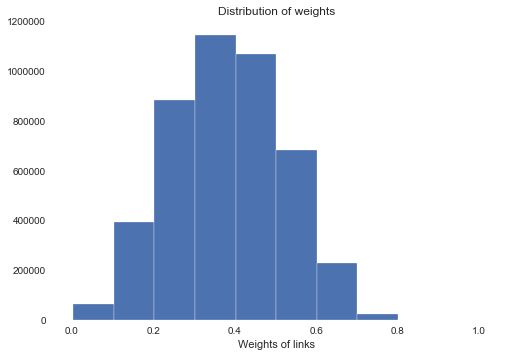

In [127]:
plt.hist(weights)
plt.title('Distribution of weights')
plt.xlabel('Weights of links')
plt.show()

In [144]:
#informatons over connectivity of main component 
adjacency=adjacency_full.copy() #we keep the original adjacency matrix
adjacency[adjacency < 0.65] = 0
graph=nx.from_numpy_matrix(adjacency)
print("#nodes= ",adjacency.shape[0])
print("#compo= ",nx.number_connected_components(graph))
list_comp=sorted(nx.connected_components(graph), key = len, reverse=True)
print("#nodes in giant component= ", len(list_comp[0]))
print("percentage of nodes in main component= ",len(list_comp[0])/adjacency.shape[0])

#nodes=  3000
#compo=  465
#nodes in giant component=  2512
percentage of nodes in main component=  0.8373333333333334


In [145]:
# list(nx.connected_component_subgraphs(graph))[0].node

In [146]:
#keep only the main component and corresponding label
conn_graph = list(nx.connected_component_subgraphs(graph))[0]
conn_label=label.iloc[list(list_comp[0])]

## Graph plot##

In [147]:
laplacian=nx.laplacian_matrix(conn_graph)

In [148]:
# conn_label.label.genre['sub'].str.split("|",expand=True).iloc[:,0]

In [149]:
# conn_label.label.genre['sub'].str.split("|",expand=True).iloc[:,0].unique()

In [150]:



# for i,name in enumerate( conn_label.label.genre['sub'].str.split("|",expand=True).stack().value_counts().to_frame(name='count').reset_index()['index']):
#     label_num[label_num==name]=5*i
#     print(name," ",5*i)
# label_num[label_num>10]=0   
# conn_label.label.genre['sub'].str.split("|",expand=True).iloc[:,0]

In [151]:
label2=np.array(conn_label.label.genre.main)
# label2=np.array(conn_label.label.genre['sub'].str.split("|",expand=True).iloc[:,0]);
label_num=label2.copy()

for i,name in enumerate( conn_label.label.genre.main.unique()):
    label_num[label_num==name]=i
    print(name," ",i)
    
# label_num[label_num=='Rock']=0
# label_num[label_num=='Hip-Hop']=1
# label_num[label_num=='Folk']=4
# label_num[label_num=='Pop']=3
# label_num[label_num=='Experimental']=4
# label_num[label_num=='Electronic']=5
# label_num[label_num=='International']=6
# label_num[label_num=='Instrumental']=7

print(label_num)

Hip-Hop   0
Folk   1
Rock   2
[0 0 1 ... 0 1 0]


In [152]:
e,eigenvectors = scipy.sparse.linalg.eigs(laplacian,k=6)

e=e.real
eigenvectors=eigenvectors.real

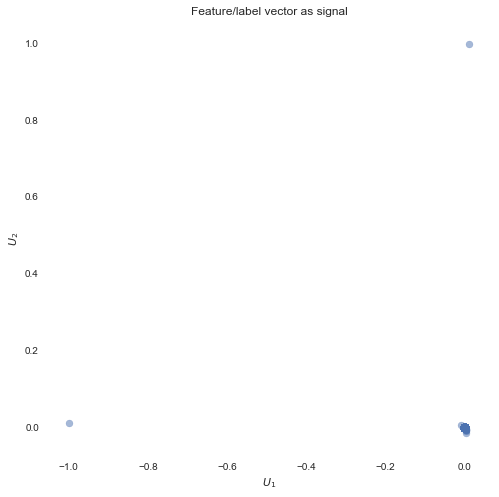

In [153]:
#using laplacian eigenmap
plt.figure(figsize=(8, 8))

plt.scatter(eigenvectors[:, 1], eigenvectors[:, 2], alpha=0.5, cmap='coolwarm')
plt.title('Feature/label vector as signal')
plt.xlabel('$U_1$')
plt.ylabel('$U_2$')
plt.show()

In [154]:
#using springlayout
coords = nx.spring_layout(conn_graph)  # Force-directed layout.

In [155]:
i=0
coords_x=[]
coords_y=[]
for i in (conn_graph.node):
    coords_x.append(coords[i][0])
    coords_y.append(coords[i][1]);   
    i+=1;
    

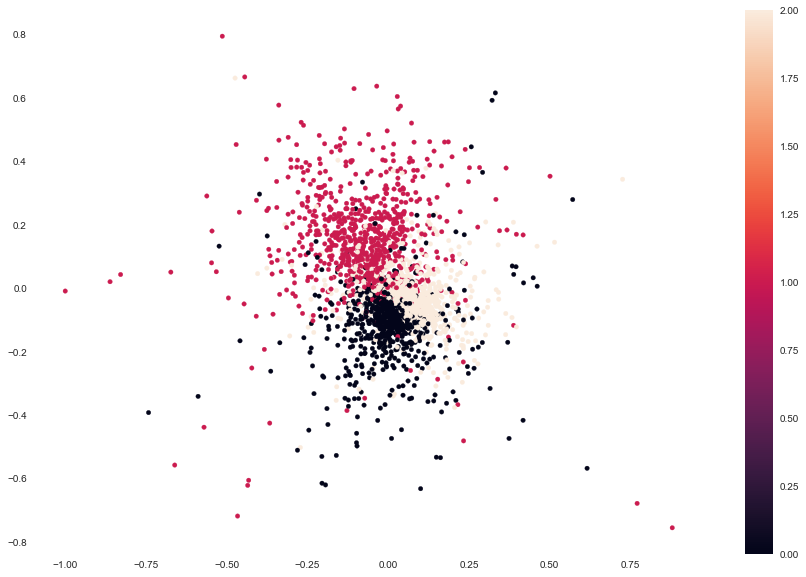

In [156]:
plt.figure(figsize=(15, 10))
nx.draw_networkx_nodes(conn_graph, coords,node_size=20, node_color=label_num)
# nx.draw_networkx_edges(conn_graph, coords, alpha=0.3)
sm = plt.cm.ScalarMappable( norm=plt.Normalize(vmin=np.min(label_num), vmax=np.max(label_num)))
sm._A = []
plt.colorbar(sm)
plt.show()

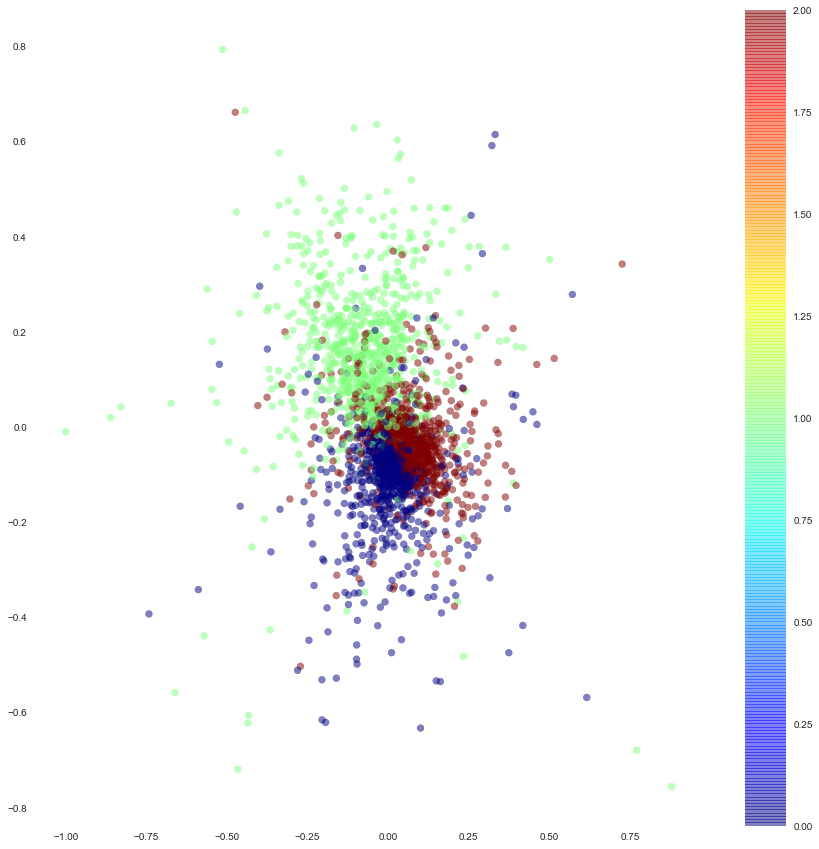

In [157]:
plt.figure(figsize=(15, 15))

plt.scatter(coords_x,coords_y,c=label_num , alpha=0.5, cmap='jet')

plt.colorbar()
plt.show()

In [25]:
tmp_label=list(np.array(conn_label.label.genre.main))

i=0;
node_dict=dict()
for n in conn_graph.node:
    node_dict[n]=i
    i+=1;
conn_graph_rename=nx.relabel_nodes(conn_graph,node_dict)

label_dict={i : tmp_label[i] for i in range(len(conn_graph.node))}
    
nx.set_node_attributes(conn_graph_rename, values=label_dict, name="genre")

In [26]:
# import random
# subnode=random.sample(list(conn_graph.node), 5000)
# sub_graph=conn_graph.subgraph(subnode)
nx.write_gexf(conn_graph_rename, "data/graph_small_HRFP.gexf")

In [27]:
# conn_graph_rename.node

# personal tests

In [28]:
dataSet

feature      chroma_cens                                              \
statistics      kurtosis                                               
number                01        02        03        04            05   
track_id                                                               
182         3.396350e-05  0.000376 -0.000262  0.000034 -9.751009e-05   
255         1.289353e-05  0.000364  0.000096  0.000028  1.080403e-04   
256         5.125153e-06  0.001845 -0.000196 -0.000051 -1.738618e-04   
368         1.387812e-04  0.000492  0.000064  0.000916  1.273574e-03   
459         1.754202e-04 -0.000357 -0.000213 -0.000146 -2.913752e-04   
574         2.744791e-05  0.000253  0.000657 -0.000092  1.066347e-03   
690        -2.795871e-06  0.000294  0.001029  0.000419  7.003378e-04   
777         6.131888e-05 -0.000175  0.000249 -0.000234 -1.162730e-05   
825         3.333279e-05  0.001129  0.000628  0.000231  7.980869e-04   
993         2.310638e-04  0.000700 -0.000182  0.000306  8.685345e-04   
1039        3.730755e-04  0.000765  0.000725  0.000223  5.172150e-04   
1040       -4.866080e-05  0.000154  0.000022  0.000218  2.830968e-05   
1087        1.957593e-04  0.000275  0.000030 -0.000042 -5.031860e-07   
1102        8.317104e-05  0.000136  0.000122 -0.000102 -2.042259e-04   
1270        1.179695e-04  0.000088 -0.000245  0.000024  7.877979e-05   
1417        7.462589e-06 -0.000237 -0.000377 -0.000056 -1.883482e-04   
1427       -4.513628e-06  0.000343  0.000065 -0.000061  4.703169e-05   
1482        1.266757e-04  0.000880 -0.000781 -0.000204 -3.188820e-04   
1706       -1.114257e-04  0.000214 -0.000357  0.000061 -1.660248e-04   
1720        4.115676e-06  0.000025 -0.000012  0.000201  1.436380e-04   
1883       -6.031610e-05 -0.000282  0.000803  0.000244  2.809155e-04   
1891       -4.243093e-06  0.000013  0.000033  0.000041  1.978485e-04   
1930        1.761533e-05 -0.000091 -0.000285 -0.000081 -2.148035e-04   
3492       -1.496031e-04 -0.000411  0.000174  0.000091  1.645150e-04   
3573        9.496619e-06  0.000211  0.000393  0.000648 -1.979946e-05   
3624        6.046472e-05 -0.000091 -0.000049  0.000088 -1.398284e-04   
3720       -2.698742e-05 -0.000217 -0.000330 -0.000104 -2.113396e-04   
3721       -3.744190e-05 -0.000114 -0.000242  0.000075 -1.660627e-04   
3722        2.297477e-04  0.000251  0.000145  0.000099  4.170611e-05   
3724       -6.104938e-05  0.000177  0.000056  0.000138 -1.059148e-04   
...                  ...       ...       ...       ...           ...   
146458     -6.676093e-05 -0.000227 -0.000357 -0.000029  2.899217e-04   
146478      4.086910e-05 -0.000189  0.000312 -0.000018  1.624948e-04   
146481     -4.121537e-05 -0.000026  0.001413  0.000210  5.247516e-04   
146482      1.194617e-04  0.000248 -0.000175  0.001168  4.573414e-04   
146483      1.662501e-04  0.000145  0.000713  0.000380  5.117937e-04   
146879     -1.595417e-04 -0.000508 -0.000656 -0.000294 -4.947543e-04   
147191      5.748619e-06 -0.000091  0.000904 -0.000060 -7.723619e-05   
147409     -2.593846e-05  0.000030  0.000330 -0.000237 -3.916489e-04   
147412     -1.211159e-04  0.000277 -0.000093 -0.000190 -2.445035e-04   
147413      3.015947e-04 -0.000237 -0.000409 -0.000219  9.460887e-05   
147780     -1.176208e-04 -0.000273  0.001185 -0.000139  7.959288e-05   
147815     -7.652560e-05 -0.000423 -0.000055 -0.000142 -3.578299e-04   
147956      6.869926e-05 -0.000280  0.000211 -0.000089 -9.874144e-05   
148246     -1.133334e-05 -0.000053 -0.000177 -0.000165 -2.638484e-04   
148439      7.765325e-07  0.000236 -0.000506  0.000668  4.001552e-05   
148441     -4.798124e-05  0.000026  0.000090  0.000523  9.797288e-05   
148443     -1.993067e-05  0.000108  0.000408  0.000106  6.436736e-04   
148444     -4.087854e-05 -0.000051 -0.000401 -0.000088 -2.526894e-05   
148536     -1.227882e-04  0.000086 -0.000546 -0.000117 -1.899144e-04   
148537     -1.054904e-04 -0.000277 -0.000396 -0.000252  1.785261e-04   
148773      3.100222e-04  0.000932 -0.00

In [29]:
genre_top=genres[genres['parent']==0]
genre_top

,#tracks,parent,title,top_level
genre_id,,,,
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5
8,868,0,Old-Time / Historic,8
9,1987,0,Country,9
10,13845,0,Pop,10
12,32923,0,Rock,12
13,730,0,Easy Listening,13


In [30]:
tracks_raw = pd.read_csv('../data/fma_metadata/raw_tracks.csv', index_col=0);
tracks_raw['track_url'][2]

'http://freemusicarchive.org/music/AWOL/AWOL_-_A_Way_Of_Life/Food'

In [31]:
# find specific sample
samples=tracks[tracks['track']['genres']=='[15]']
samples_in_small=samples[samples['set']['subset'] == 'medium']
samples_in_small

album                                            \
         comments         date_created        date_released   
track_id                                                      
397             0  2009-01-07 11:04:01  2007-01-01 00:00:00   
398             0  2008-11-26 02:01:54  2005-07-05 00:00:00   
399             0  2008-11-26 02:01:54  2005-07-05 00:00:00   
400             0  2009-01-07 11:04:01  2007-01-01 00:00:00   
405             0  2008-11-26 02:01:54  2005-07-05 00:00:00   
414             0  2008-11-26 02:01:54  2005-07-05 00:00:00   
550             0  2008-11-26 02:08:19  2009-01-08 00:00:00   
664             0  2008-11-26 02:14:23  2002-10-01 00:00:00   
665             0  2009-01-08 12:05:17  2009-01-08 00:00:00   
878             0  2008-11-26 02:25:39  2009-01-08 00:00:00   
881             0  2008-11-26 02:25:52  2009-01-12 00:00:00   
889             0  2008-11-26 02:25:39  2009-01-08 00:00:00   
1085            0  2008-11-26 02:34:28  2003-01-20 00:00:00   
1086            0  2008-11-26 02:34:28  2003-01-20 00:00:00   
1088            0  2008-11-26 02:34:28  2003-01-20 00:00:00   
1089            0  2008-11-26 02:34:28  2003-01-20 00:00:00   
1121            0  2008-11-26 02:38:27  2009-01-14 00:00:00   
1339            0  2008-11-26 02:48:07  1995-01-01 00:00:00   
1481            0  2008-11-26 02:58:25  2007-01-01 00:00:00   
1483            0  2008-11-26 02:58:25  2007-01-01 00:00:00   
1485            0  2008-11-26 02:58:25  2007-01-01 00:00:00   
1486            0  2008-11-26 02:58:24  2009-01-16 00:00:00   
1634            0  2008-11-26 03:06:22  2006-01-01 00:00:00   
1635            0  2008-11-26 03:06:22  2006-01-01 00:00:00   
1638            0  2008-11-26 03:06:22  2006-01-01 00:00:00   
1640            0  2008-11-26 03:06:22  2006-01-01 00:00:00   
1677            0  2008-11-26 03:07:47  2009-01-23 00:00:00   
1678            0  2008-11-26 03:07:47  2009-01-23 00:00:00   
3268            0  2008-12-04 09:27:11  2008-09-29 00:00:00   
3452            0  2008-12-04 09:27:17  2008-10-14 00:00:00   
...           ...                  ...                  ...   
145800          0  2016-11-03 15:38:21                  NaN   
145801          0  2016-11-03 15:38:21                  NaN   
145802          0  2016-11-03 15:38:21                  NaN   
145803          0  2016-11-03 15:38:21                  NaN   
145804          0  2016-11-03 15:38:21                  NaN   
145805          0  2016-11-03 15:38:21                  NaN   
147919          0  2016-12-16 17:21:41                  NaN   
147920          0  2016-12-16 17:21:41                  NaN   
147921          0  2016-12-16 17:21:41                  NaN   
147922          0  2016-12-16 17:21:41                  NaN   
147923          0  2016-12-16 17:21:41                  NaN   
147924          0  2016-12-16 17:21:41                  NaN   
148960          0  2017-01-05 17:21:03  2017-01-06 00:00:00   
148961          0  2017-01-05 17:21:03  2017-01-06 00:00:00   
148962          0  2017-01-05 17:21:03  2017-01-06 00:00:00   
151026          0  2017-02-06 14:47:39  2016-06-11 00:00:00   
151654          0  2017-02-09 16:56:41  2013-08-09 00:00:00   
152317          0  2017-02-13 15:07:42  2011-09-16 00:00:00   
152318          0  2017-02-13 15:07:42  2011-09-16 00:00:00   
152319          0  2017-02-13 15:07:42  2011-09-16 00:00:00   
152322          0  2017-02-13 15:24:45  2011-11-04 00:00:00   
152323          0  2017-02-13 15:24:45  2011-11-04 00:00:00   
152546          0  2017-02-15 14:56:34                  NaN   
152550          0  2017-02-15 14:56:34                  NaN   
152552          0  2017-02-15 14:56:34                  NaN   
152553          0  2017-02-15 14:56:34                  NaN   
152554          0  2017-02-15 14:56:34                  NaN   
152704          0  2017-02-17 23:53:05  2005-10-16 00:00:00   
152720          0  2017-02-18 00:07:12  2007-12-27 00:00:00   
152721          0  2017-02-18 00:07:12  200

In [32]:
label['label']['genre']['main'].unique()

array(['Rock', 'Electronic'], dtype=object)